In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import signal

import numpy as np
import pandas as pd

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from mvee import EllipsoidTool as ET

In [2]:
wsrc = '../clean2/'
tsrc = '../watershed/'
dst =  '../rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

rotX, rotY, rotZ = False, False, False

walnut_batch = sorted(glob.glob( wsrc + '*/' ))
bidx = -1
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))

bname = walnut_batch[bidx].split('/')[-2]

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

../rotated/SelectD_R9_T1/


In [3]:
widx = 1
print(walnut_files[widx])

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))

img = tf.imread(walnut_files[widx])
mxval = 2**(8*img.itemsize)

../clean2/SelectD_R9_T1/SelectD_R9_T1_002.tif
SelectD_R9_T1_002


In [4]:
NNN = 25
bottom = img[:NNN,:, :]
top = img[-NNN:, :, :]

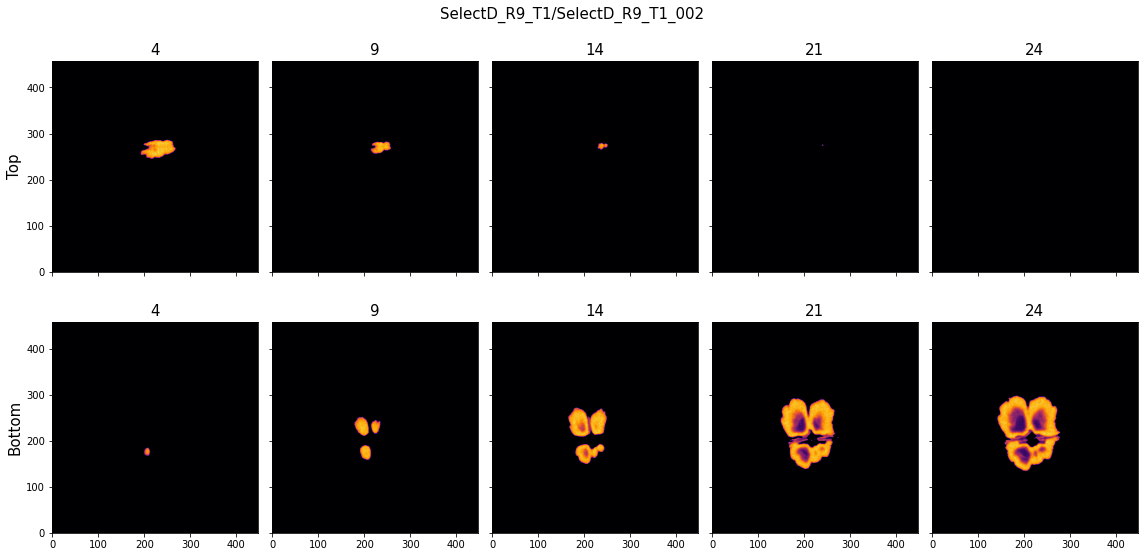

In [5]:
thrs = [4,9,14,21,24]
ssp = [np.s_[t,:,:] for t in thrs]
ssn = [np.s_[-t,:,:] for t in thrs]

fig, ax = plt.subplots(2,len(thrs),figsize=(16,8), sharex=True, sharey=True)

for i in range(len(thrs)):
    ax[0,i].imshow(top[ssp[i]], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[0,i].set_title(thrs[i], fontsize=fs)
for i in range(len(thrs)):
    ax[1,i].imshow(bottom[ssp[i]], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[1,i].set_title(thrs[i], fontsize=fs)
    
ax[0,0].set_ylabel('Top', fontsize=fs)
ax[1,0].set_ylabel('Bottom', fontsize=fs)
    
fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

Top:	 23542
Bot:	 132705 

Base is at the Bottom
Tipvox:	 [553 275 240]


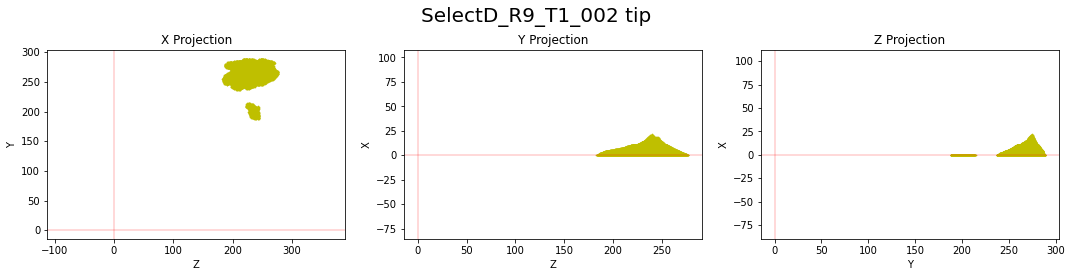

In [6]:
reload(wnut)
topsum = np.sum(top > 0)
botsum = np.sum(bottom > 0)

print('Top:\t', topsum)
print('Bot:\t', botsum,'\n')

if botsum > topsum:
    coords = np.asarray(np.nonzero(top))
    tipvox = wnut.find_tip_max(coords, 2,1,0)
    tipvox[0] += (img.shape[0] - NNN)
    
    print('Base is at the Bottom\nTipvox:\t', tipvox)
    
else:
    coords = np.asarray(np.nonzero(bottom))
    tipvox = wnut.find_tip_min(coords, 2,1,0)
    
    print('Tip is at the Bottom\nTipvox:\t', tipvox)
    
_ = wnut.plot_3Dprojections(coords, fname + ' tip', alpha=1, writefig=False, dst=wdst);

### Surface area

In [7]:
bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
nutarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
nutvoxarea = np.sum(border)

print('Border made of\t', nutvoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(nutarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(nutarea),2), 'mm')

bcoords = np.asarray(np.nonzero(border))
wmean = np.mean(bcoords, axis = 1)

datapoints = bcoords - wmean.reshape(-1,1)
datapoints *= resol

tipcoord = tipvox - wmean
tipcoord *= resol

Border made of	 581658 pixels

Nut surface area:	 6258.26 mm^2
Approx by a square of size:	 79.11 mm


*:	 [21.30970996  3.5531683   1.22502403]


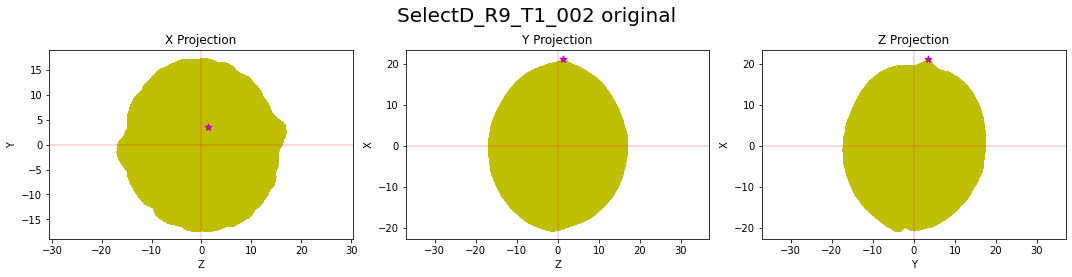

In [9]:
fig,ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=1, writefig=False, dst=wdst);

ax[0].scatter(tipcoord[2], tipcoord[1], marker='*', s=50, c='m')
ax[1].scatter(tipcoord[2], tipcoord[0], marker='*', s=50, c='m')
ax[2].scatter(tipcoord[1], tipcoord[0], marker='*', s=50, c='m');

print('*:\t', tipcoord)

### Alignment

In [10]:
et = ET()
hull = spatial.ConvexHull(datapoints.T)
phull = hull.points[hull.vertices]
mvee_origin, mvee_radii, mvee_rotation = et.getMinVolEllipse(phull, 1e-2)

In [17]:
ccoords = (datapoints + mvee_origin.reshape(-1,1)).copy()
ccoords = mvee_rotation @ ccoords

rotmax = tipcoord + mvee_origin
rotmax = mvee_rotation @ rotmax

if rotmax[2] < 0:
    ccoords[2] *= -1.
    rotmax[2] *= -1.
    rotX = True
    print('rot')

rot


*:	 [-1.0141372   0.15626207 22.00866384]


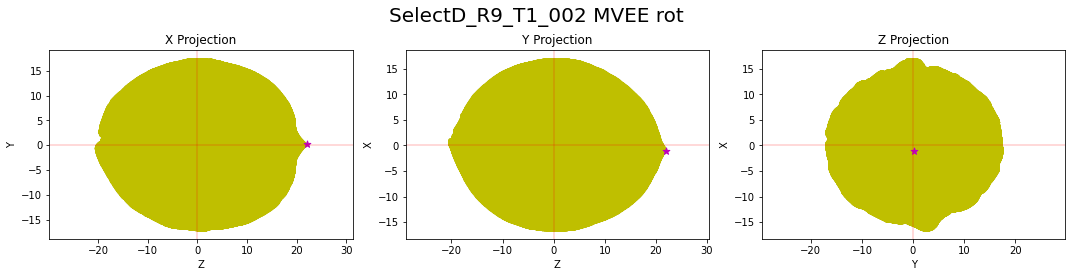

In [18]:
fig,ax = wnut.plot_3Dprojections(ccoords, fname + ' MVEE rot', alpha=1, writefig=False, dst=wdst);

ax[0].scatter(rotmax[2], rotmax[1], marker='*', s=50, c='m')
ax[1].scatter(rotmax[2], rotmax[0], marker='*', s=50, c='m')
ax[2].scatter(rotmax[1], rotmax[0], marker='*', s=50, c='m');

print('*:\t', rotmax)

In [19]:
tipz = np.max(ccoords, axis=1)[2]
tipy = ccoords[1][ccoords[2] == tipz][0]
tipx = ccoords[0][ccoords[2] == tipz][0]

print(tipx, tipy, tipz, sep='\t')

thetay = np.arccos(tipz/np.sqrt(tipz**2 + tipx**2))
thetax = np.arccos(tipz/np.sqrt(tipz**2 + tipy**2))

print(np.rad2deg([thetax, thetay]))

bulgerotx = np.array([[1,0,0], 
                      [0, np.cos(thetax), -np.sin(thetax)],
                      [0, np.sin(thetax),  np.cos(thetax)]])

bulgeroty = np.array([[np.cos(thetay), 0,  np.sin(thetay)],
                      [0,1,0],
                      [-np.sin(thetay), 0, np.cos(thetay)]])

if (tipx > 0) and (tipy > 0):
    rotxy = bulgerotx @ bulgeroty.T
elif (tipx > 0) and (tipy <= 0):
    rotxy = bulgerotx.T @ bulgeroty.T
elif (tipx <= 0) and (tipy > 0):
    rotxy = bulgerotx @ bulgeroty
else:
    rotxy = bulgerotx.T @ bulgeroty
    
rcoords = rotxy @ ccoords

-1.0141371957461582	0.1562620726237808	22.008663843369316
[0.40679466 2.63826596]


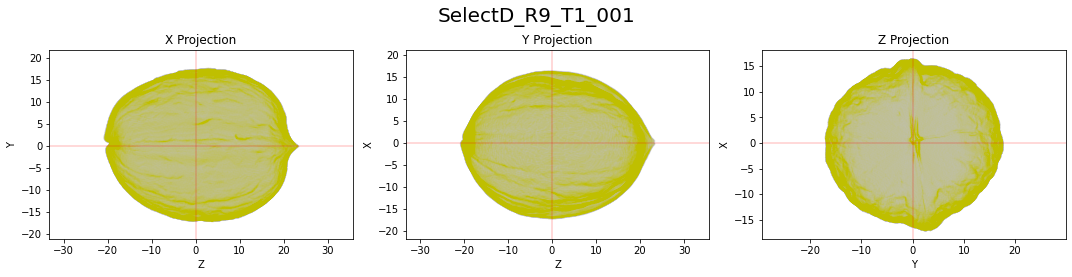

In [20]:
fig, ax = wnut.plot_3Dprojections(rcoords, fname, alpha=0.01, writefig=False, dst=wdst);

(2, 32953) 
---
PARAMS
---
axes	:
[16.87821663 15.58640062]
origin	:
[ 0.07658253 -0.09002468]
theta	:
0.14240183702451908
rot	:
[[ 0.98987798 -0.14192105]
 [ 0.14192105  0.98987798]]
theta	 8.16 deg


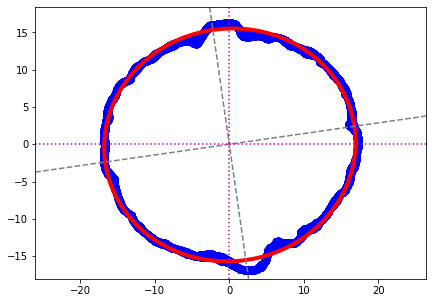

In [21]:
thr = 1
acoords = np.abs(rcoords)
tcoords = np.flip(rcoords[:2, (acoords[2] < thr)])
print(tcoords.shape,'\n---\nPARAMS\n---')

V = wnut.ell_algebraic_fit_2d(*tcoords)
pdict = wnut.get_ell2d_params_from_vector(V)
for key in pdict:
    print(key, '\t:\n', pdict[key], sep='')
print('theta\t',np.round(np.rad2deg(pdict['theta']),2),'deg')

# Plot the noisy data
plt.figure(figsize=(7,5))
plt.scatter(*tcoords, label='Data Points', c='blue')

# Plot the least squares ellipse
x_coord = np.linspace(np.min(tcoords)-1, np.max(tcoords)+1, 300)
y_coord = x_coord
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = V[0] * X_coord ** 2 + V[1] * X_coord * Y_coord + V[2] * Y_coord**2 + V[3] * X_coord + V[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=4);
plt.axis('equal');

plt.axline(xy1=(0,0), slope = np.tan(pdict['theta']), c='gray', ls='--')
plt.axline(xy1=(0,0), slope = -1/np.tan(pdict['theta']), c='gray', ls='--');

plt.axvline(0, c='m', ls=':')
plt.axhline(0, c='m', ls=':');

In [22]:
print('equancy\n---\n')
print('MVEE:',radii,radii[0]/radii[1], sep='\t')
#print('BFAE:',ell_params['axes'], ell_params['axes'][2]/ell_params['axes'][0], sep='\t')

equancy
---

MVEE:	[16.92851852 17.55097925 22.11679515]	0.9645341311222653


In [23]:
Q = pdict['rot'].T @ (tcoords - pdict['origin'].reshape(-1,1))
distances = np.zeros((Q.shape[1], 4))

for i in range(Q.shape[1]):
    distances[i] = wnut.d_ell_point(Q[0,i], Q[1,i], pdict)

P = pdict['rot'] @ (distances[:, 2:].T + pdict['origin'].reshape(-1,1))

In [24]:
phi = np.arccos(distances[:,2]/pdict['axes'][0])
phi[distances[:,3] < 0] = 2*np.pi - phi[distances[:,3] < 0]

stack = wnut.even_space_ell0(721, *pdict['axes'])
idxs = np.digitize(phi, bins=stack[0])
print(np.min(idxs), np.max(idxs))

sumdist = np.zeros(len(stack[0])-1)
for i in range(len(sumdist)):
    sumdist[i] = np.mean(distances[idxs == i+1, 0]*distances[idxs == i+1, 1])
sumdist[sumdist < 0] = 0

if np.argmax(sumdist) < len(sumdist)//2:
    rotZ = True
    print('rot')
    
cval = np.max(np.abs(tcoords))/np.max(sumdist)

1 720


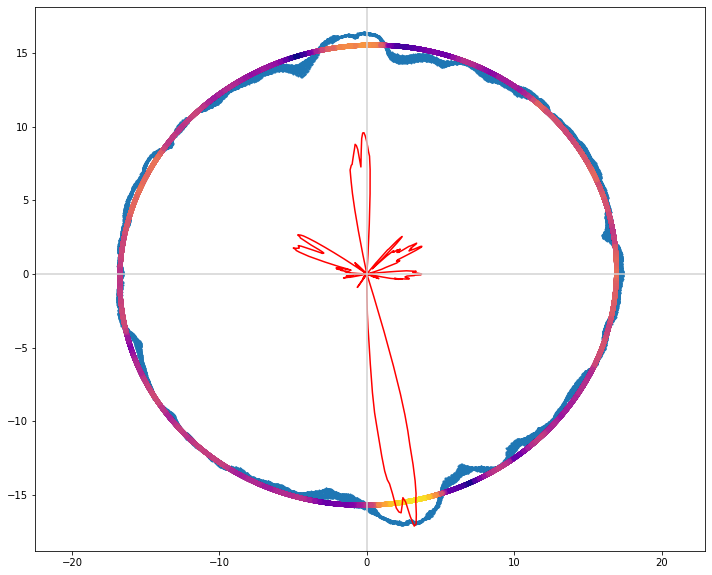

In [25]:
# Plot the noisy data
plt.figure(figsize=(12,10))
plt.scatter(*tcoords, s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
#plt.scatter(*Q, c=distances[:,0]*distances[:,1], cmap='plasma')

#plt.scatter(*ell0, c='gray', marker='o', s=15)
plt.scatter(*P, s=15, c=distances[:,0]*distances[:,1], cmap='plasma')
#plt.scatter(distances[:,2], distances[:,3], c=distances[:,0]*distances[:,1], cmap='plasma')

#plt.scatter(2*pdict['axes'][0]*np.cos(phi),2*pdict['axes'][1]*np.sin(phi), c=distances[:,0]*distances[:,1], cmap='plasma')

#plt.scatter(*stack[1:]*1.5, marker='^', c='blue', s=15)

plt.plot(cval*sumdist*np.cos(stack[0][:-1] + pdict['theta']), cval*sumdist*np.sin(stack[0][:-1] + pdict['theta']), c='r')

plt.axvline(0, c= 'lightgray')
plt.axhline(0, c= 'lightgray')
plt.axis('equal');

filename = 'seal_finding.jpg'
#plt.savefig(filename, dpi=150, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

1.6741388169981355 95.92108853301765


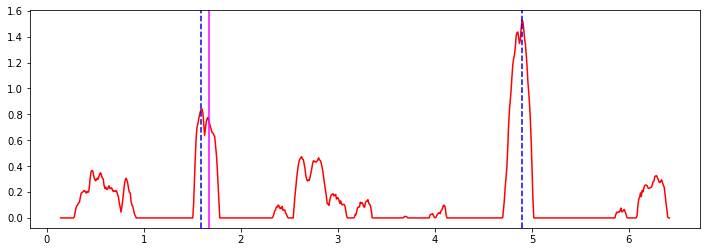

In [26]:
sumdist3 = np.hstack((sumdist,sumdist,sumdist))
rawpeakidx, _ = signal.find_peaks(sumdist3, distance=len(sumdist)//4)
foo = rawpeakidx[(rawpeakidx > len(sumdist)) & (rawpeakidx < 2*len(sumdist))]
srtpeakidx = foo[np.argsort(sumdist3[foo])[-2:][::-1]] - len(sumdist)

bulge = np.mean(stack[0][srtpeakidx]) - np.pi*.5 + pdict['theta']

if rotZ:
    bulge += np.pi
    print(rot)

print(bulge, np.rad2deg(bulge))
#meanpeak 

plt.figure(figsize=(12,4))
plt.plot(stack[0][:-1] + pdict['theta'], sumdist, c='r');
for x in stack[0][srtpeakidx] + pdict['theta']:
    plt.axvline(x, c='blue', ls='--');
plt.axvline(bulge, c='magenta');

In [30]:
bulgerotz = np.array([[np.cos(bulge), -np.sin(bulge), 0],
                      [np.sin(bulge),  np.cos(bulge), 0],
                      [0, 0, 1]])
rotxyz = bulgerotz @ rotxy

bulgerot2d = bulgerotz[:2,:2]

../rotated/SelectD_R9_T1/SelectD_R9_T1_001_seal.jpg


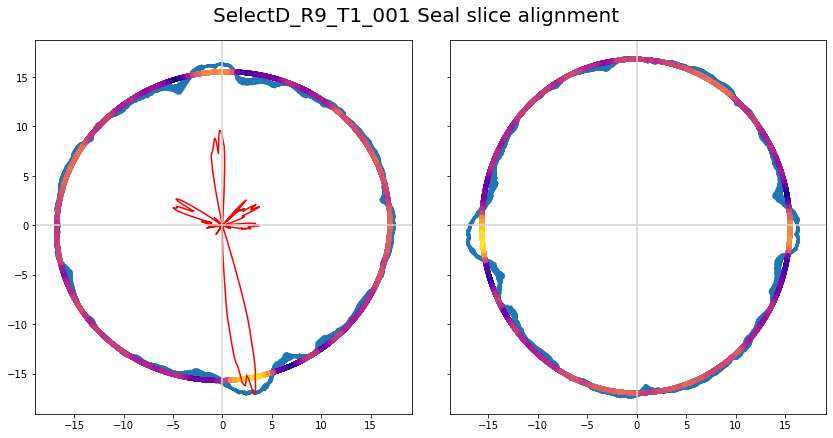

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12,6), sharex=True, sharey=True)

ax[0].scatter(*tcoords, s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[0].scatter(*P, s=15, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[0].plot(cval*sumdist*np.cos(stack[0][:-1] + pdict['theta']), cval*sumdist*np.sin(stack[0][:-1] + pdict['theta']), c='r')

ax[1].scatter(*(bulgerot2d.T @ tcoords), s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[1].scatter(*(bulgerot2d.T @ P), s=15, c=distances[:,0]*distances[:,1], cmap='plasma')

for i in range(len(ax)):
    ax[i].axvline(0, c= 'lightgray')
    ax[i].axhline(0, c= 'lightgray')
    ax[i].set_aspect('equal');

fig.suptitle(fname + ' Seal slice alignment', fontsize=20)
fig.tight_layout()

filename = wdst + fname + '_seal.jpg'
print(filename)
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

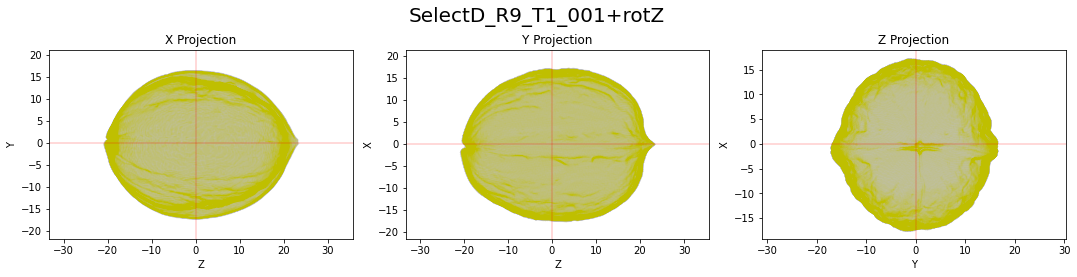

In [31]:
rotccoords = rotxyz @ ccoords
fig, ax = wnut.plot_3Dprojections(rotccoords, fname + '+rotZ', alpha=0.01, writefig=True, dst=wdst);

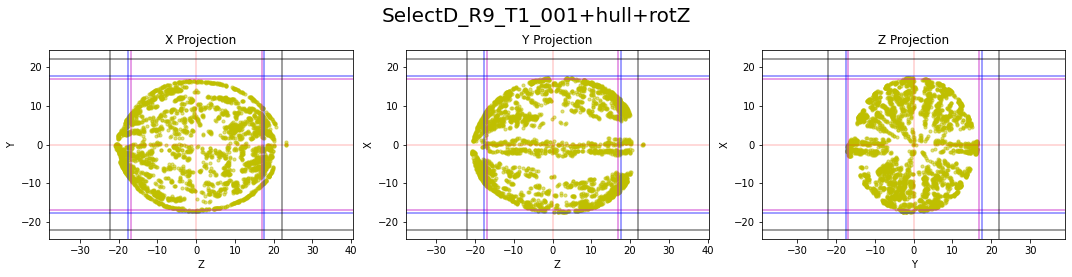

In [39]:
color = ['m','b','k']

hcoords = phull.T + origin.reshape(-1,1)
hcoords = rotation @ hcoords
hcoords = rotxyz @ hcoords

#rotccoords[0] *= -1

fig, ax = wnut.plot_3Dprojections(hcoords, fname + '+hull+rotZ', 10, 0.5, 'o', writefig=False, dst=wdst);

for j in range(3):
    for i in range(len(radii)):
        ax[j].axvline( radii[i], c=color[i], alpha=0.5)
        ax[j].axvline(-radii[i], c=color[i], alpha=0.5)

        ax[j].axhline( radii[i], c=color[i], alpha=0.5)
        ax[j].axhline(-radii[i], c=color[i], alpha=0.5)

In [40]:
minis = np.min(hcoords, axis=1)
maxes = np.max(hcoords, axis=1)

rdsrtmax = np.zeros(len(minis))
rdsrtmin = np.zeros(len(minis))

print(minis, maxes, sep='\n')

print('\n', (maxes - minis)/2, '\n')

for i in range(3):
    bar = minis + radii[i]
    rdsrtmin[i] = np.argmin(np.abs(bar))

    print(i, bar, rdsrtmin[i], sep='\t')
    
print()

for i in range(3):
    bar = radii[i] - maxes
    rdsrtmax[i] = np.argmin(np.abs(bar))
    print(i, bar, rdsrtmax[i], sep='\t')
    
print(rdsrtmin, rdsrtmax, np.all(rdsrtmin == rdsrtmax), sep='\t')

[-17.43690554 -17.19249217 -20.80779777]
[17.2153105  16.36464455 23.29166299]

 [17.32610802 16.77856836 22.04973038] 

0	[-0.50838701 -0.26397365 -3.87927924]	1.0
1	[ 0.11407372  0.35848708 -3.25681851]	0.0
2	[4.67988962 4.92430298 1.30899739]	2.0

0	[-0.28679197  0.56387397 -6.36314447]	0.0
1	[ 0.33566876  1.1863347  -5.74068374]	0.0
2	[ 4.90148465  5.7521506  -1.17486784]	2.0
[1. 0. 2.]	[0. 0. 2.]	False


In [41]:
print(radii)
pd.DataFrame(rotccoords.T, columns=['X','Y','Z']).describe()

[16.92851852 17.55097925 22.11679515]


,X,Y,Z
count,625833.000000,625833.000000,625833.000000
mean,-0.247530,-0.159103,0.533673
std,9.928776,9.311307,11.758531
min,-17.436906,-17.192492,-20.807798
25%,-8.742263,-8.210995,-9.202817
50%,-0.451804,-0.089889,0.643658
75%,8.221670,8.001468,10.290236
max,17.215310,16.364645,23.291663


In [ ]:
align = np.vstack((origin, radii, rotation, bulgerotz, 
                   minis, maxes, rdsrtmin, rdsrtmax,
                   np.array([rotX,rotY,rotZ]).astype(int)))
filename = wdst + fname + '_rotation.csv'
print(filename)
np.savetxt(filename, align, delimiter=',')